## Portfolio Optimisation

Firstly, let's talk about portfolio optimisation then we can move onto the Modern Portfolio Theory. Portfolio optimisation can just be defined as "how to maxmise an objective function that relates to your portfolio while ensuring that the weights sum to 1".

Now that objective function can be anything that can be defined by the user. It can be the risk adjusted returns of your whole portfolio, it can be just maximising returns or it can be to minimise the overall variance of your portfolio.

In mathematical terms, the problem can be stated as:
$
\max_{weights} f(X, weights)
$
subject to the contraints:
$
\sum_{i} weights_{i} = 1
$

where $f(X, weights)$ is your objective function and $X$ is the returns dataframe of your tickers.

## Modern Portfolio Theory

Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz and published under the title "Portfolio Selection" in the Journal of Finance in 1952.

There are a few underlying concepts that can help anyone to understand MPT. If you are familiar with finance, you might know what the acronym "TANSTAAFL" stands for. It is a famous acronym for "There Ain't No Such Thing As A Free Lunch". This concept is also closely related to 'risk-return trade-off'.

Higher risk is associated with greater probability of higher return and lower risk with a greater probability of smaller return. MPT assumes that investors are risk-averse, meaning that given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns.

Another factor comes in to play in MPT is "diversification". Modern portfolio theory says that it is not enough to look at the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the benefits of diversification – chief among them, a reduction in the riskiness of the portfolio.

What you need to understand is "risk of a portfolio is not equal to average/weighted-average of individual stocks in the portfolio". In terms of return, yes it is the average/weighted average of individual stock's returns, but that's not the case for risk. The risk is about how volatile the asset is, if you have more than one stock in your portfolio, then you have to take count of how these stocks movement correlates with each other. The beauty of diversification is that you can even get lower risk than a stock with the lowest risk in your portfolio, by optimising the allocation.

In [82]:
import yfinance as yfin
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.optimize as sco
import matplotlib.pyplot as plt
import utils
import quant_risk as qr

%load_ext autoreload
%autoreload 2

plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# Define any random tickers that we have in our portfolio
tickers = ['AAPL','AMZN','GOOGL','FB']

# Download the tickers using Yahoo Finance
dataframe = yfin.download(tickers, period='1y')['Adj Close']

# First fill forward and then drop the NA values
dataframe = dataframe.ffill().dropna()

[*********************100%***********************]  4 of 4 completed


In [84]:
dataframe.head()

,AAPL,AMZN,FB,GOOGL
Date,,,,
2020-10-07,114.344559,3195.689941,258.119995,1459.140015
2020-10-08,114.235252,3190.550049,263.760010,1483.430054
2020-10-09,116.222473,3286.649902,264.450012,1510.449951
2020-10-12,123.604996,3442.929932,275.750000,1564.589966
2020-10-13,120.326073,3443.629883,276.140015,1567.069946


In [85]:
# Taking the daily returns of our dataframe
returns = dataframe.pct_change().dropna()

returns.head()

,AAPL,AMZN,FB,GOOGL
Date,,,,
2020-10-08,-0.000956,-0.001608,0.021850,0.016647
2020-10-09,0.017396,0.030120,0.002616,0.018214
2020-10-12,0.063521,0.047550,0.042730,0.035844
2020-10-13,-0.026527,0.000203,0.001414,0.001585
2020-10-14,0.000743,-0.023208,-0.015644,-0.002316


Let us look at the price series of our dataframe and how the Adj Close price has been this past year

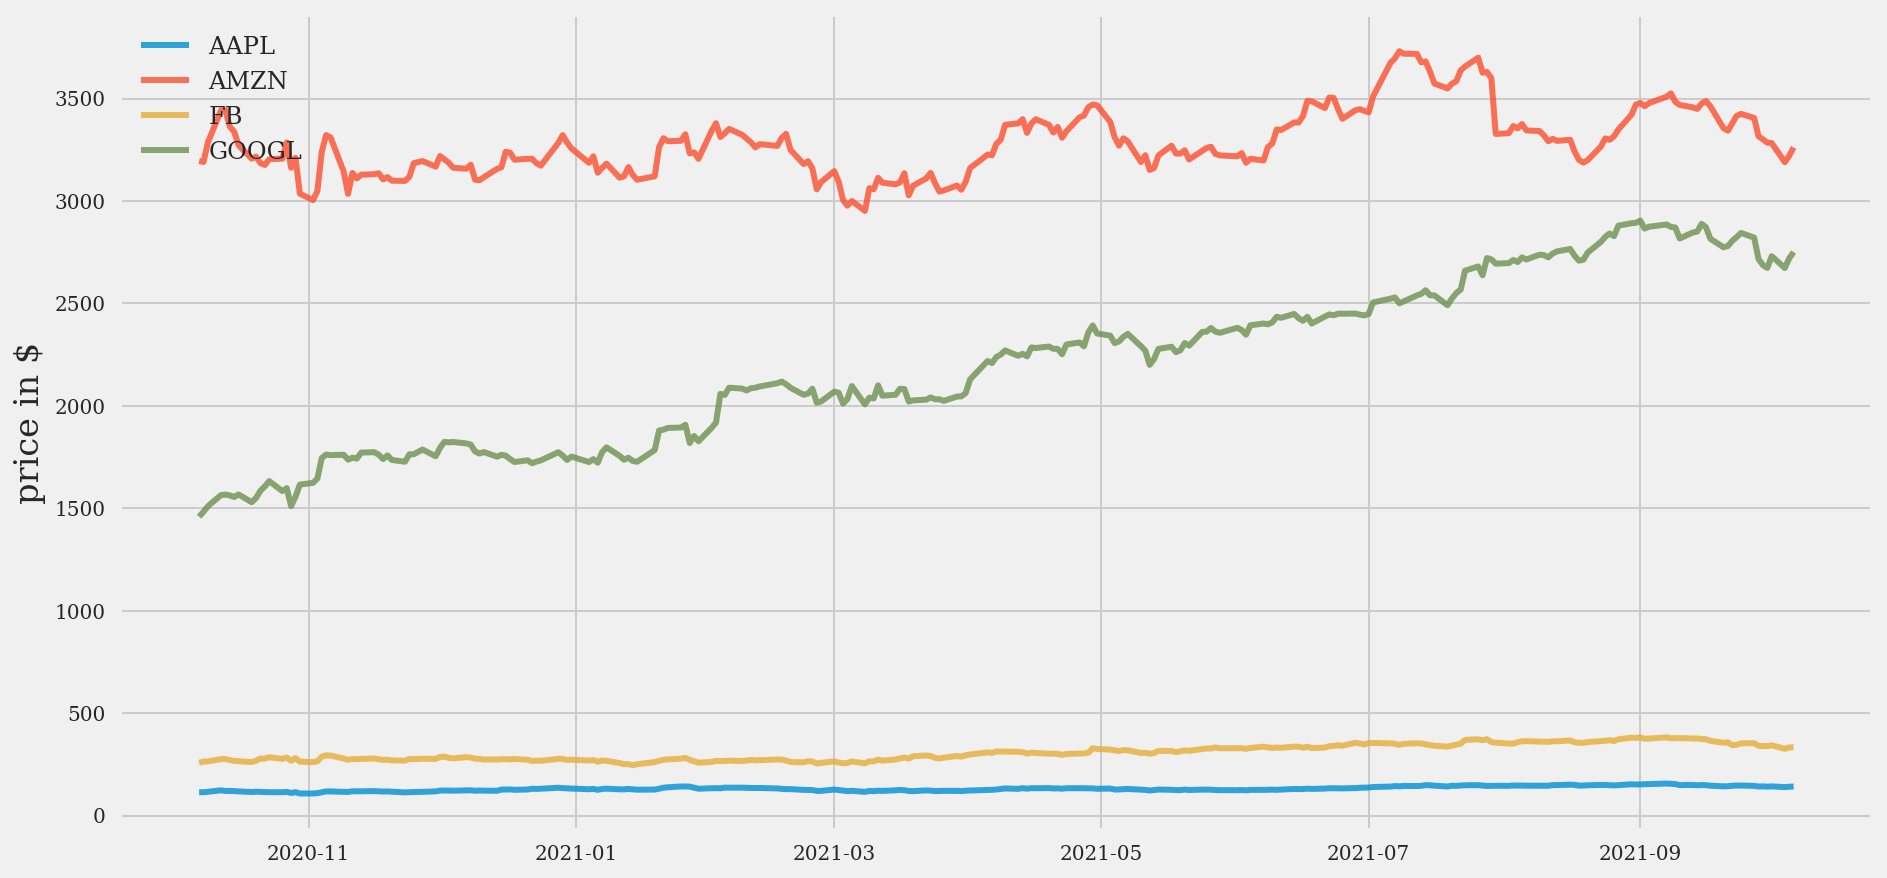

In [86]:
utils.plot_series(dataframe)

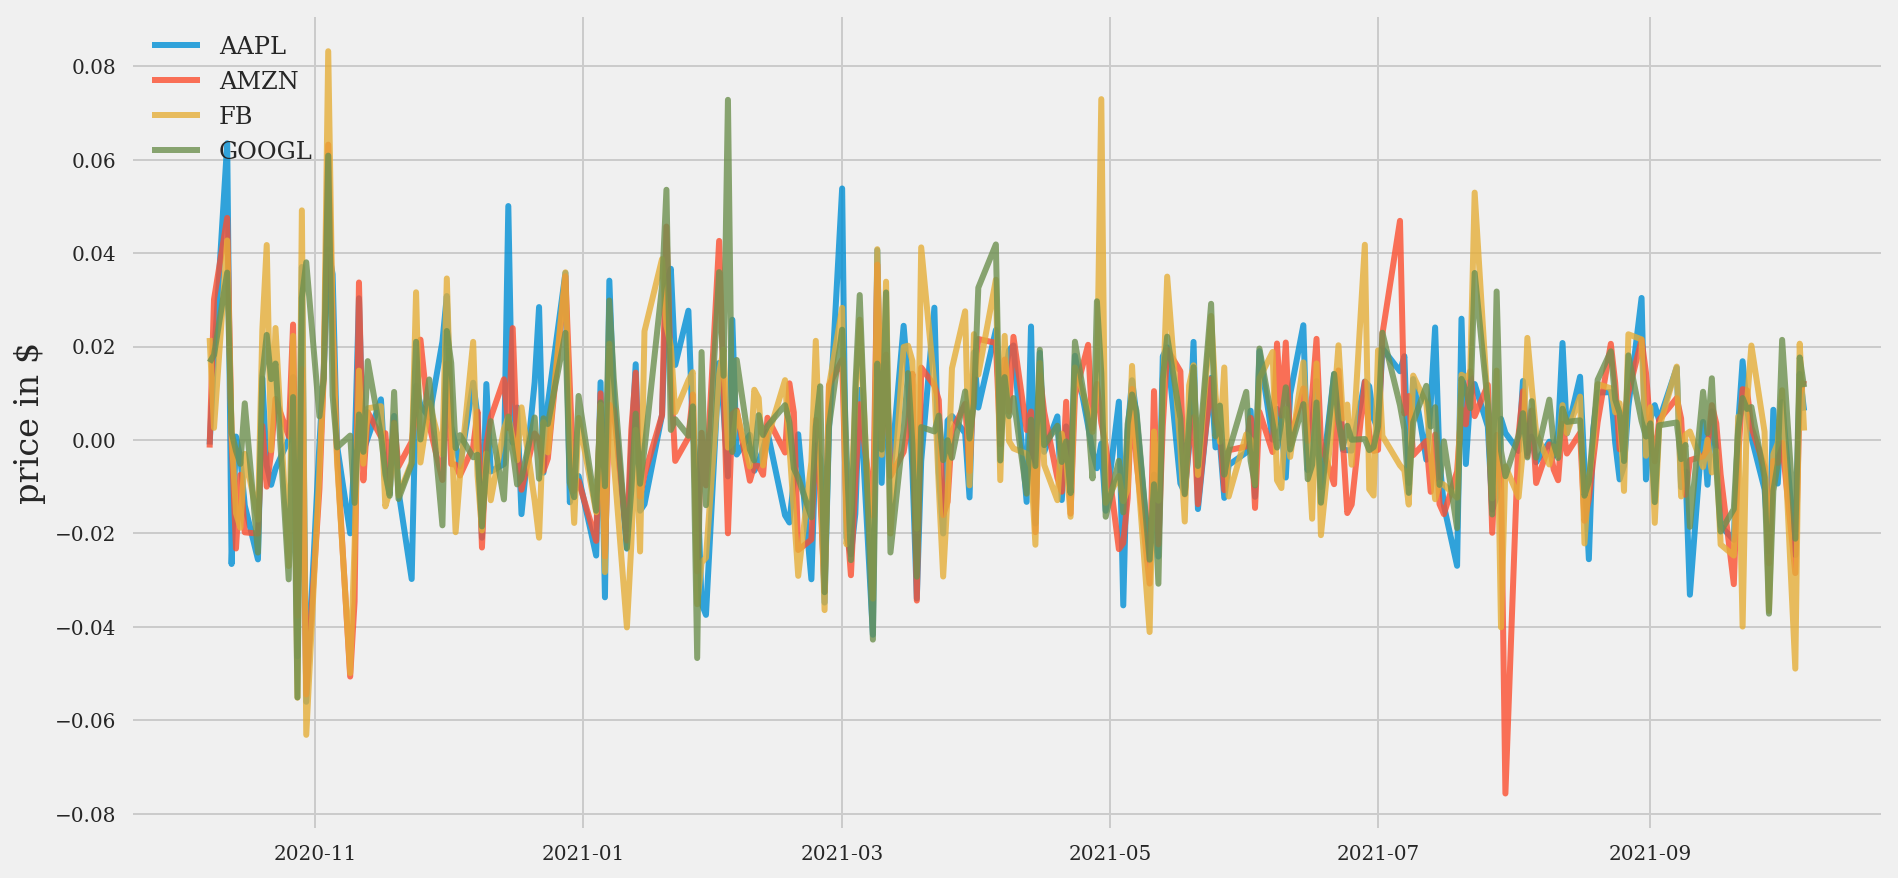

In [87]:
utils.plot_series(returns)

## Why Variance is not linear in summation?


$
Var(X + Y) \neq Var(X) + Var(Y)
$

Variance is not linear under the summation sign, there is the additional term of covariance between the two random variables that also exists.

$
Var(X + Y) = Var(X) + Var(Y) + 2Cov(X, Y)
$

and because of this fact, we see that higher risk may not always mean a higher return, sometimes, we can get a higher return from our portfolio while keeping the volatility of the portfolio constant.


## Creating random portfolios

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return:  0.89
Annualised Volatility:  0.25
Sharpe Ratio:  3.43

            AAPL  AMZN   FB  GOOGL
allocation   0.0   0.0  0.0    1.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return:  0.45
Annualised Volatility:  0.22
Sharpe Ratio:  2.06

                AAPL      AMZN   FB     GOOGL
allocation  0.225593  0.335143  0.0  0.439264


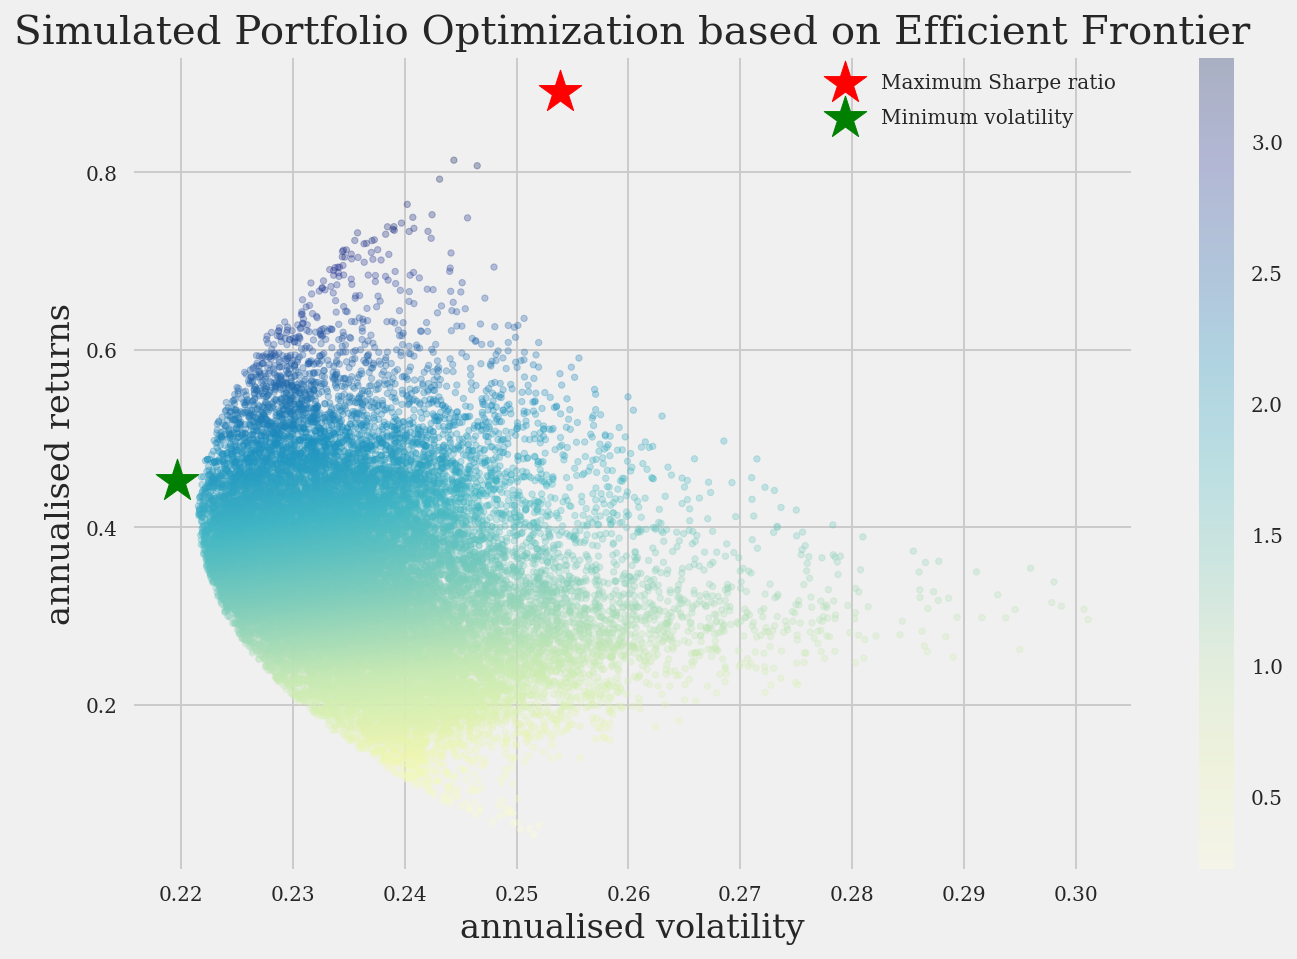

In [88]:
number_of_portfolios = 25000
risk_free_rate = 0

utils.display_simulated_ef_with_random(dataframe,
                            number_of_portfolios, risk_free_rate)

## Efficient Frontier
From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

If you are an advanced Excel user, you might be familiar with 'solver' function in excel. Scipy's optimize function is doing the similar task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated.

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

## How to build your own Mean Variance portfolio

In this tutorial, we will demonstate how to build your own portfolio that maximises your sharpe ratio or one that minimizes the total variance of your portfolio

In [99]:
def neg_sharpe_ratio(weights, dataframe, risk_free_rate = 0):

    # Multiply prices by the weights assigned to them and then sum across each date to get portfolio value
    portfolio = (weights * dataframe).sum(axis=1)

    # Calculate the sharpe ratio of our portfolio and return the negative of that
    return -qr.statistics.financial_ratios.sharpe_ratio(portfolio, risk_free_rate)

In [101]:
def max_sharpe_ratio(dataframe, risk_free_rate = 0):

    # How many assets do we have in our portfolio
    num_assets = len(dataframe.columns)

    # What are the additional arguements that our objective function needs
    args = (dataframe)
    # What are the constraints on our optimisation
    # Here it is that the sum of the weights must equal to one
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # What are the individual bouds for each weight
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [102]:
max_sharpe_ratio(dataframe)

     fun: -3.5133723173882134
     jac: array([ 0.10479885,  4.9432478 ,  0.31691822, -0.        ])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 2.77555756e-17, 1.00000000e+00])

In [104]:
def portfolio_volatility(weights,dataframe):

    # Calculate our portfolio returns for each date
    portfolio = (dataframe.pct_change().dropna() * weights).sum(axis=1)

    return qr.statistics.annualize.annualised_volatility(portfolio)

def min_variance(dataframe):

    num_assets = len(dataframe.columns)

    args = (dataframe)

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [105]:
min_variance(dataframe)

     fun: 0.22200110436447848
     jac: array([0.22226712, 0.22138135, 0.23447692, 0.22232788])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.21724808, 0.33128722, 0.        , 0.4514647 ])